In [18]:
# Imports
from prelim_calculations import Calculate
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import csv
from demand_calculation import *
import os
import time

In [19]:
class Request:

    def __init__(self):
        self.API_URL = "https://phonebox.tegola.org.uk/api_jsonrpc.php"
        self.NUM_VALUES = 1        # Data is collected every 3 minutes
        self.username = "yeyao"
        self.password = "ci5WeJoh"

        # Router -> Internet IDs
        self.rti_ids = [["47072", "47073", "47068", "47061"], ["47707", "47722", "47711"], ["45623"], ["46494"], ["46640", "46641"], 
           ["46131"], ["52250", "44809", "44811", "48758", "48759", "48760", "48761"], 
           ["46367", "46359", "46362", "46365", "46366"], ["45626", "45625", "45639"]]

        # Internet -> Router IDs
        self.itr_ids = [["47123", "47124", "47119", "47112"], ["47851", "47866", "47855"], ["45791"], ["46539"], ["46682", "46683"], 
           ["46074"], ["44896", "44898", "48803", "48804", "48805", "48806", "52256"], 
           ["46404", "46407", "46410", "46411", "46412"], ["45794", "45793", "45807"]]
        
        self.mhi_gateway_upstream_id = "47118"
        self.mhi_gateway_downstream_id = "47067"
        self.smo_gateway_upstream_id = "47852"
        self.smo_gateway_downstream_id = "47708"
        self.gateway_id_list = [self.mhi_gateway_upstream_id, self.mhi_gateway_downstream_id, self.smo_gateway_upstream_id, self.smo_gateway_downstream_id]
        self.token = self.get_auth_token()

    # Generate the authentication token for login
    def get_auth_token(self):
        result = ""

        # JSON login request
        try:
            data = {
            "jsonrpc": "2.0",
            "method": "user.login",
            "params": {
                "user": self.username,
                "password": self.password
            },
            "id": 1,
            "auth": None
            }
            req = requests.post(self.API_URL, json=data)
            result = req.json()["result"]
        except:
            exit()
        return result

    # Build a trend request
    def build(self, start, end, ids):
        data = {
            "jsonrpc": "2.0",
            "method": "trend.get",
            "params": {
                "time_from": int(time.mktime(start)),
                "time_till": int(time.mktime(end)),
                "itemids": ids,
                "sortfield": "clock",
                "sortorder": "DESC",
                "output": [
                    "itemid",
                    "clock",
                    "value_avg" # should be able to change this to max/min if necessary
                ]
            },
            "auth": self.token,
            "id": 1
        }

        req = requests.post(API_URL, json=data)
        return ast.literal_eval(req.text)["result"]

In [20]:
# Gather the traffic for a 5-day period to show the cyclic nature of the traffic and peak times

start_date = datetime.datetime(2023, 2, 1, 0, 0).timetuple()
end_date = datetime.datetime(2023, 2, 6, 0, 0).timetuple()
req = Request()

gateway_dataset = [req.build(start_date, end_date, id) for id in req.gateway_id_list]

AttributeError: module 'matplotlib.pyplot' has no attribute 'mdates'

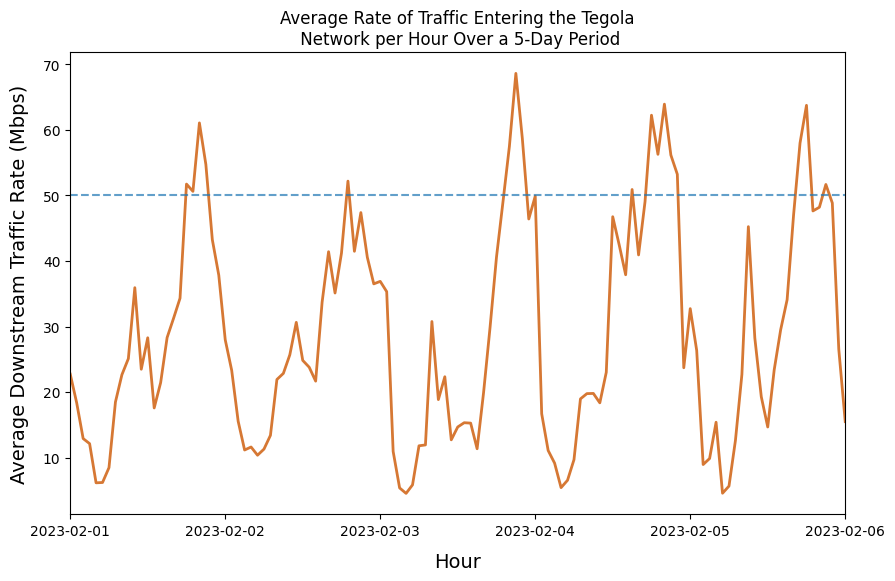

In [32]:
# Clean and plot the data for 5-day period
import matplotlib.dates as mdates

gateway_df = pd.DataFrame()
gateway_df["time"] = pd.DataFrame.from_records(gateway_dataset[0])["clock"]
i = 0
for item in gateway_dataset:
    df_temp = pd.DataFrame.from_records(item)
    gateway_df[str(i)] = df_temp["value_avg"].astype(int) * 0.000001
    i += 1
gateway_df["4"] = gateway_df.loc[:,['2','3']].sum(axis=1)
gateway_df["5"] = gateway_df["time"].apply(lambda x: datetime.datetime.fromtimestamp(int(x)))
xmin = datetime.datetime.fromtimestamp(1675209600)
xmax = datetime.datetime.fromtimestamp(1675641600)
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(gateway_df["5"], gateway_df["4"], color="chocolate", alpha = 0.9, linewidth = 2)
ax.hlines(50, xmin, xmax, linestyle = 'dashed', alpha = 0.7)
ax.set_ylabel("Average Downstream Traffic Rate (Mbps)", fontsize=14, labelpad=10)
ax.set_xlabel("Hour", fontsize=14, labelpad=10)
ax.set_title("Average Rate of Traffic Entering the Tegola\n Network per Hour Over a 5-Day Period")
ax.set_xlim(xmin, xmax)
ax.xaxis.set_major_formatter(matplotlib.mdates.DateFormatter('%Y-%m-%d'))

In [ ]:
# Retrieve all the data for the last month of gateway traffic
start_date = datetime.datetime(2023, 1, 1, 0, 0).timetuple()
end_date = datetime.datetime(2023, 1, 31, 23, 59).timetuple()
req = Request()
# item 1: upstream mhi, item 2: downstream mhi, item 3: upstream smo, item 4: downstream smo
gateway_dataset = [req.build(start_date, end_date, id) for id in req.gateway_id_list]


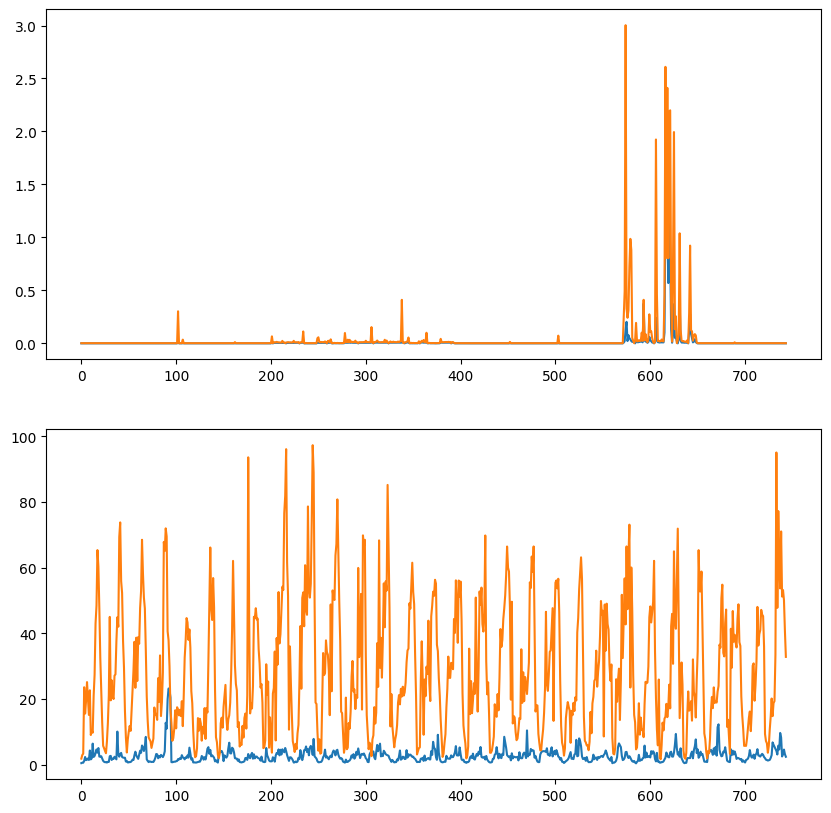

In [ ]:
# Build and plot graphs for the average network traffic every hour over a monthlong period
gateway_df = pd.DataFrame()
gateway_df["time"] = pd.DataFrame.from_records(gateway_dataset[0])["clock"]
i = 0
for item in gateway_dataset:
    df_temp = pd.DataFrame.from_records(item)
    gateway_df[str(i)] = df_temp["value_avg"].astype(int) * 0.000001
    i += 1
fig, ax = plt.subplots(2,1, figsize=(10,10))
ax[0].plot(gateway_df["0"])
ax[0].plot(gateway_df["1"])
ax[1].plot(gateway_df["2"])
ax[1].plot(gateway_df["3"])

[0.00127712 0.00129679 0.00136196 0.00127392 0.00160687 0.00121033
 0.0013325  0.00130279 0.00387587 0.00554617 0.00513108 0.00419592
 0.00655679 0.00742467 0.00543004 0.00531921 0.00362821 0.00115875
 0.00120854 0.00118271 0.00128717 0.00121354 0.00119417 0.01635396
 0.03774946 0.28265092 0.07214233 0.00196721 0.001309   0.00134833]


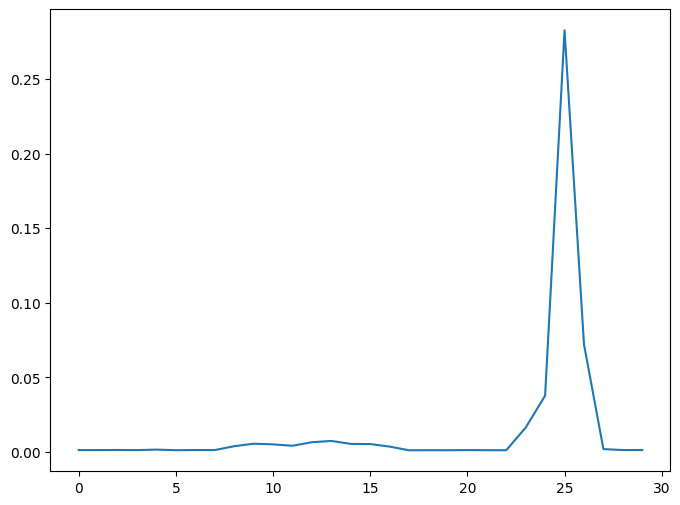

In [ ]:
# Adjust timescale to per-day traffic and plot for a less noisy graph
new = np.zeros(30)
for i in range(30):
    x = gateway_df["0"][24 * i:24 * (i + 1)]
    new[i] = sum(x) / 24
print(new)

new_df = pd.DataFrame(new)

fig, ax = plt.subplots(1,1, figsize=(8,6))
ax.plot(new_df)